In [1]:
import os
import librosa
import librosa.display
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
#from plot_audio import plot_specgram, plot_waveform
os.getcwd()

/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


'/Users/jansta/learn/acoustics'

In [3]:
from audio_ds_model import get_mel_spect, AudioDataset, AudioClassifNet
from training_func import run_training

/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
dict_mats = np.load('/Users/jansta/learn/acoustics/dict_mats_dB.npy', allow_pickle=True).item()


In [5]:
len(dict_mats['A']['can_opening'][3])
all_labels = dict_mats['A'].keys()
print(all_labels)

dict_keys(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'])


In [6]:
chosen_labels = ['crickets', 'can_opening', 'dog','chirping_birds', 'chainsaw', 'crying_baby', 'rooster', 'sea_waves','toilet_flush'][:4]

In [7]:
chosen_labels = list(all_labels)
encoded_labels = {}
for i, label in enumerate(chosen_labels):
    encoded_labels[label] = i

In [27]:
np.save('encoded_labels.npy', encoded_labels)
print(encoded_labels)

{'dog': 0, 'chirping_birds': 1, 'vacuum_cleaner': 2, 'thunderstorm': 3, 'door_wood_knock': 4, 'can_opening': 5, 'crow': 6, 'clapping': 7, 'fireworks': 8, 'chainsaw': 9, 'airplane': 10, 'mouse_click': 11, 'pouring_water': 12, 'train': 13, 'sheep': 14, 'water_drops': 15, 'church_bells': 16, 'clock_alarm': 17, 'keyboard_typing': 18, 'wind': 19, 'footsteps': 20, 'frog': 21, 'cow': 22, 'brushing_teeth': 23, 'car_horn': 24, 'crackling_fire': 25, 'helicopter': 26, 'drinking_sipping': 27, 'rain': 28, 'insects': 29, 'laughing': 30, 'hen': 31, 'engine': 32, 'breathing': 33, 'crying_baby': 34, 'hand_saw': 35, 'coughing': 36, 'glass_breaking': 37, 'snoring': 38, 'toilet_flush': 39, 'pig': 40, 'washing_machine': 41, 'clock_tick': 42, 'sneezing': 43, 'rooster': 44, 'sea_waves': 45, 'siren': 46, 'cat': 47, 'door_wood_creaks': 48, 'crickets': 49}


In [8]:
transform = transforms.Compose(
    [transforms.Resize((64,431)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [9]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)
datasetB = AudioDataset(dict_mats['B'], chosen_labels, encoded_labels, transform=transform)

# # Split dataset
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 4
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(datasetB, batch_size=batch_size, shuffle=True)



In [10]:
# Test the dataloader
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Input batch size: {inputs.size()}")
    print(f"Labels: {labels}")
    print("-" * 30)
    break  # Just to test the first batch

Batch 1:
Input batch size: torch.Size([4, 1, 64, 431])
Labels: tensor([24, 15, 38, 16])
------------------------------


In [11]:
def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")
        return True
    return False

In [12]:
## Create an  instance of the model:
n_classes = len(chosen_labels)
model = AudioClassifNet(n_classes)
rate_l = 0.0005

In [ ]:
for _ in range(3): 
    losses_epoch_mean, acc, cm = run_training(model, train_loader, val_loader, n_classes, rate_l=0.001, NUM_EPOCHS = 10, save=True)

In [14]:
# y_val = []
# y_val_hat = []
# for i, data in enumerate(val_loader):
#     inputs, y_val_temp = data
#     with torch.no_grad():
#         y_val_hat_temp = model(inputs).round()
    
#     y_val.extend(y_val_temp.numpy())
#     y_val_hat.extend(y_val_hat_temp.numpy())

In [ ]:

# # Accuracy
# acc = accuracy_score(y_val, np.argmax(y_val_hat, axis=1))
# print(f'Accuracy: {acc*100:.2f} %')
# # confusion matrix
# cm = confusion_matrix(y_val, np.argmax(y_val_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels)


In [16]:
#torch.save(model.state_dict(), f'audio_classification_model10_LR{rate_l}_a{acc*100:.0f}%.pth')

In [16]:
m = np.load('outputs/results_and_model_acc_79.3_LR_0.001_nclasses_9.npy', allow_pickle=True).item()['model']

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/results_and_model_acc_79.3_LR_0.001_nclasses_9.npy'

In [ ]:
#f = torch.load('audio_classification_model10_LR0.001_a85%.pth', map_location=torch.device('cpu'))
model = AudioClassifNet(9)
model.load_state_dict(m)
model.eval()

In [17]:
import pydub
file_path = 'ESC-50/audio/1-12653-A-15.wav'






In [21]:

import io
spectrogram_image = get_mel_spect(file_path)
# Add a channel dimension
sample = np.expand_dims(spectrogram_image, axis=0)
sample2 = torch.FloatTensor(sample)
input_img = transform(sample2)


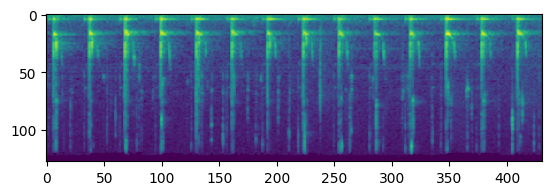

In [25]:
plt.imshow(sample[0,:,:])

In [ ]:
#label = torch.tensor(label, dtype=torch.long)
  
# Make prediction - call model
with torch.no_grad():
    output = model(input_img.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    predicted_label = chosen_labels[predicted.item()]

In [ ]:
predicted_label

In [34]:
import functools
import time
from tqdm import tqdm

In [14]:
print(len(dataset.y))
print(len(datasetB.y))



1527
317
